In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

def conf_intvl(xs):
    return st.t.interval(0.95, len(xs)-1, loc=np.mean(xs), scale=st.sem(xs))


In [30]:
env = 'LunarLanderContinuous-v2' # 'AntBulletEnv-v0', 'LunarLanderContinuous-v2', BipedalWalker-v3, 'HalfCheetahBulletEnv-v0'
resultspath = f'data/results'
gamma = 0.98

baseline = pd.read_csv(f'{resultspath}/{env}/baseline.csv').rename(columns={'discounted_rewards': 'V'})
afrl = pd.read_csv(f'{resultspath}/{env}/experiments.csv').rename(columns={'discounted_rewards': 'V'})

base_mean = baseline.V.mean()
base_low, base_hgh = conf_intvl(baseline.V)

af_means = afrl.groupby('delta').V.mean()
af_low, af_hgh = list(zip(*afrl.groupby('delta').V.apply(conf_intvl)))

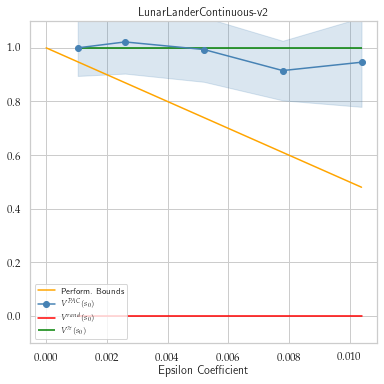

In [31]:
import seaborn as sns
sns.set_theme(style="whitegrid")


settings = {
    'LunarLanderContinuous-v2': {
        'max_score': 70, # (discounted?) ep reward
        'min_score': -100,
    }
}
def mk_plot(env, i):
    # ax = plt.subplot(3,2,i+1)
    ax = plt.subplot(1,1,1)
    afrl = pd.read_csv(f'{resultspath}/{env}/experiments.csv').rename(columns={'discounted_rewards': 'V'})
    vmax, vmin = settings[env]['max_score'], settings[env]['min_score']
    vmax = afrl.groupby('delta').V.mean().values[0]
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.delta / vrange
    # baseline['opt'] = (baseline.V - vmin) / vrange
    base_mean = 1
    # base_low, base_hgh = conf_intvl(baseline.opt)
    af_means = afrl.groupby('eps').opt.mean()
    sd = afrl.groupby('eps').opt.std().values
    delta_low, delta_hgh = afrl.eps.min(), afrl.eps.max()
    delta = np.linspace(0, delta_hgh, 2)
    subopt = delta / (1 - gamma)
    plt.plot(delta, base_mean-subopt, color='orange', label='Perform. Bounds')
    af_means.plot(label='$V^{PAC}(s_0)$', marker='o', ax=ax, color='steelblue') # =E_{a\sim AFRL}[\sum \gamma^t R(s_t, a_t)]
    plt.fill_between(af_means.index, af_means-sd, af_means+sd, alpha=0.2, color='steelblue')
    plt.hlines(base_mean, delta_low, delta_hgh, color='green', label='$V^\pi(s_0)$') # =E_{a\sim\pi}[\sum \gamma^t R(s_t, a_t)]
    # plt.fill_between((delta_low, delta_hgh), base_low, base_hgh, color='green', alpha=0.2)

    plt.plot([delta_low, delta_hgh], [0,0], color='red', label='$V^{rand}(s_0)$')

    if i == 2:
        plt.ylabel('Performance')
    plt.xlabel('Epsilon Coefficient')
    # plt.title('$V(s_0) / \epsilon$')
    # plt.legend(prop={'size': 12})
    plt.ylim(-.1, 1.1)

    # if i % 2 == 1: # is second row
    #     ax.yaxis.set_ticklabels([])
    #     plt.ylabel('')
    # if i < 4: # is not last col
    #     ax.xaxis.set_ticklabels([])
    #     plt.xlabel('')
    # if i == 0:
    plt.legend(loc='lower left', fontsize="x-small")

    # ax = plt.subplot(6,2,i+2)
    # f_means = afrl.groupby('eps').forecast.mean()
    # f_low, f_hgh = np.array(list(zip(*afrl.groupby('eps').forecast.apply(conf_intvl))))
    # f_means.plot(marker='o', ax=ax, label='$V^F(s_0)$', color='steelblue')
    # plt.fill_between(f_means.index, np.where(f_low < 0, 0, f_low), f_hgh, alpha=0.2, color='steelblue')


plt.figure(figsize=(5.5, 5.5))
for i, env in enumerate([env]):
    mk_plot(env, i)
    plt.title(env)
    # plt.legend()
# plt.suptitle(f'{env} ($\gamma={gamma}$)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.suptitle('Theoretical Perfomance Bounds')
plt.tight_layout()
# plt.savefig('../results/figures/bounds')


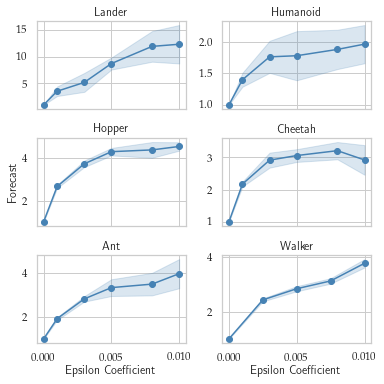

In [27]:
import seaborn as sns
sns.set_theme(style="whitegrid")


def mk_plot(env, i):
    ax = plt.subplot(3,2,i+1)
    env_name = envs[env]['name']
    afrl = pd.read_csv(f'data/deltas/{algo}/{env_name}/experiments2.csv').rename(columns={'discounted_rewards': 'V', 'Unnamed: 0': 'episode'})
    afrl2 = pd.read_csv(f'data/deltas/{algo}/{env_name}/experiments3.csv').rename(columns={'discounted_rewards': 'V', 'Unnamed: 0': 'episode'})
    afrl2.episode = afrl2.episode + 3
    import os
    if os.path.exists(f'data/deltas/{algo}/{env_name}/experiments4.csv'):
        afrl3 = pd.read_csv(f'data/deltas/{algo}/{env_name}/experiments3.csv').rename(columns={'discounted_rewards': 'V', 'Unnamed: 0': 'episode'})
        afrl3.episode += 9
        afrl = pd.concat([afrl, afrl2, afrl3])
    else:
        afrl = pd.concat([afrl, afrl2])
    vmax, vmin = envs[env]['max'], envs[env]['min']
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.delta / vrange

    ax = plt.subplot(3,2,i+1)
    f_means = afrl.groupby('eps').forecast.mean() + 1
    sd = afrl.groupby(['eps', 'episode']).forecast.mean().unstack().std(1)

    f_low, f_hgh = f_means + sd, f_means - sd
    f_means.plot(marker='o', ax=ax, label='$V^F(s_0)$', color='steelblue')
    plt.fill_between(f_means.index, np.where(f_low < 0, 0, f_low), f_hgh, alpha=0.2, color='steelblue')

    plt.xlabel('Epsilon Coefficient')

    if i % 2 == 1: # is second row
        # ax.yaxis.set_ticklabels([])
        plt.ylabel('')
    if i < 4: # is not last col
        ax.xaxis.set_ticklabels([])
        plt.xlabel('')
    if i == 2:
        plt.ylabel('Forecast')    



plt.figure(figsize=(5.5, 5.5))
for i, env in enumerate(envs):
    mk_plot(env, i)
    plt.title(env)
    # plt.legend()
# plt.suptitle(f'{env} ($\gamma={gamma}$)')
# plt.suptitle('Forecast for Perfomance Bounds')
plt.tight_layout()
plt.savefig('../results/figures/bounds-forecast')


/home/josiah/miniconda3/envs/afrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


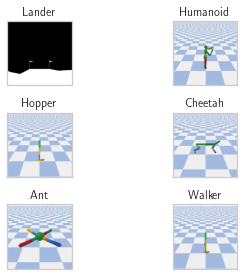

In [26]:
import gym
import pybullet_envs

import sys
sys.path.insert(0,'/home/josiah/code/afrl/afrl')
from env_meta import envs

envs2 = ([gym.make(env['name']) for env in envs.values()])
imgs = []
for env in envs2:
    env.render('rgb_array')
    env.reset()
    # env.step(env.action_space.sample())
    imgs.append(env.render('rgb_array'))
    env.close()
import matplotlib.pyplot as plt

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

for i, img in enumerate(imgs):
    plt.subplot(3, 2, i+1)
    diff = img.shape[1] - img.shape[0]
    trim = diff // 2
    img = img[:,trim:img.shape[1]-trim,:]
    
    plt.imshow(img)
    # plt.frame(off)
    plt.xticks([])
    plt.yticks([])
    plt.title(list(envs.keys())[i])

plt.tight_layout()